In [2]:
import pandas as pd
import numpy as np
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chisquare, norm


In [3]:
df = pd.read_csv("./data_ab.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.shape

(294478, 5)

# Шаг 1. EDA и подготовка


1. проверим дубликаты юзеров

In [5]:
len(df) == df["user_id"].nunique()

False

In [6]:
dupes = df["user_id"].value_counts()
dupes[dupes > 1]

user_id
805339    2
754884    2
722274    2
783176    2
898232    2
         ..
847058    2
889392    2
664150    2
835401    2
736955    2
Name: count, Length: 3894, dtype: int64

In [7]:
dupes_ids = dupes[dupes > 1].index
duplicate_rows = df[df["user_id"].isin(dupes_ids)]
duplicate_rows_sorted = duplicate_rows.sort_values(by="user_id")


duplicate_rows_sorted

,user_id,timestamp,group,landing_page,converted
230259,630052,2025-01-17 01:16:05.208766,treatment,new_page,0
213114,630052,2025-01-07 12:25:54.089486,treatment,old_page,1
22513,630126,2025-01-14 13:35:54.778695,treatment,old_page,0
251762,630126,2025-01-19 17:16:00.280440,treatment,new_page,0
183371,630137,2025-01-20 02:08:49.893878,control,old_page,0
...,...,...,...,...,...
142354,945703,2025-01-08 19:40:51.169351,control,new_page,0
186960,945797,2025-01-13 17:23:21.750962,control,old_page,0
40370,945797,2025-01-11 03:04:49.433736,control,new_page,1
165143,945971,2025-01-16 10:09:18.383183,control,old_page,0


In [8]:
#часть дубликатов

(7788/294478)*100

2.6446797383845313

In [9]:
#удаляем дубликаты
# найдём user_id, которые встречаются > 1 раза
dupes_ids = df["user_id"].value_counts()
dupes_ids = dupes_ids[dupes_ids > 1].index

# удалим ВСЕ строки этих пользователей из df
df_clean = df[~df["user_id"].isin(dupes_ids)].copy()

df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


2. удаляем несовпадения

In [10]:
df_clean = df[
    ((df["group"] == "treatment") & (df["landing_page"] == "new_page")) |
    ((df["group"] == "control") & (df["landing_page"] == "old_page"))
]
df_clean

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


In [11]:
len(df) - len(df_clean)

3893

In [12]:
df_final = df_clean.sort_values("timestamp").drop_duplicates(subset="user_id", keep="first")
df_final.shape

(290584, 5)

In [13]:
df = df_final

3. делим на 2 датасета один - df_control, второй - df_treatment

In [14]:
df_control = df[df["group"]=="control"]
df_control.head()

,user_id,timestamp,group,landing_page,converted
184884,781507,2025-01-02 13:42:15.234051,control,old_page,0
83878,737319,2025-01-02 13:42:21.786186,control,old_page,0
112584,799109,2025-01-02 13:42:45.219901,control,old_page,0
126997,643921,2025-01-02 13:43:03.767329,control,old_page,1
189698,677659,2025-01-02 13:43:32.744957,control,old_page,0


In [15]:
df_treatment = df[df["group"]=="treatment"]
df_treatment.head()

,user_id,timestamp,group,landing_page,converted
131228,922696,2025-01-02 13:42:05.378582,treatment,new_page,0
102717,818377,2025-01-02 13:42:26.640581,treatment,new_page,0
158789,725857,2025-01-02 13:42:27.851110,treatment,new_page,0
191378,762651,2025-01-02 13:42:28.522322,treatment,new_page,0
111830,722516,2025-01-02 13:42:34.033708,treatment,new_page,0


In [16]:
df_control.shape

(145274, 5)

In [17]:
df_treatment.shape

(145310, 5)

In [18]:
n_control = len(df_control)
n_treatment = len(df_treatment)
total = n_control + n_treatment

print("Control %:", n_control/total * 100)
print("Treatment %:", n_treatment/total * 100)

Control %: 49.99380557773312
Treatment %: 50.00619442226688


гипотеза: доли групп соответствуют ожидаемым

In [19]:
counts = df["group"].value_counts().reindex(["control","treatment"])
chi_srm, p_srm = chisquare(counts.values, f_exp=[counts.sum()/2]*2)

print("SRM chi2:", chi_srm)
print("SRM p-value:", p_srm)

SRM chi2: 0.004459984032155934
SRM p-value: 0.9467543681597944


Небольшая разница в размере групп — норма.
При случайном распределении и последующей очистке данных группы почти никогда
не получаются равными.
Главное, что перекос минимальный — значит сплит корректен.

# 2.проверка сплита

In [20]:
import pandas as pd
from scipy.stats import chi2_contingency

# выделяем день
df["date"] = pd.to_datetime(df["timestamp"]).dt.date

# считаем количество пользователей по дням и группам
daily_counts = (
    df.groupby(["date", "group"])["user_id"]
    .nunique()
    .unstack(fill_value=0)
)

daily_counts

group,control,treatment
date,,
2025-01-02,2859,2853
2025-01-03,6590,6618
2025-01-04,6578,6541
2025-01-05,6427,6505
2025-01-06,6606,6747
2025-01-07,6604,6609
2025-01-08,6687,6700
2025-01-09,6628,6615
2025-01-10,6654,6696


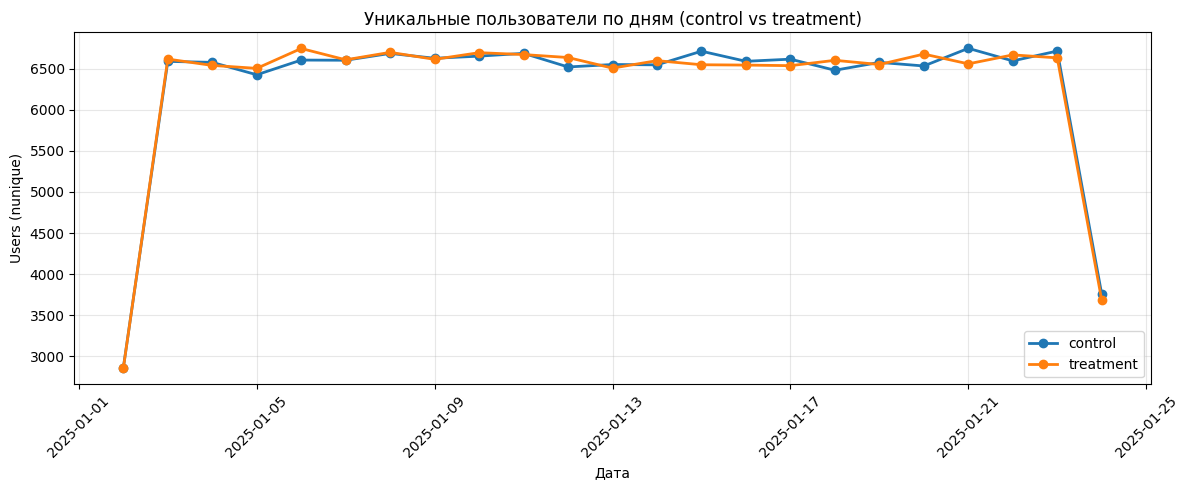

In [21]:
# на всякий случай приводим индекс к datetime
dc = daily_counts.copy()
dc.index = pd.to_datetime(dc.index)

plt.figure(figsize=(12, 5))
plt.plot(dc.index, dc["control"], marker="o", linewidth=2, label="control")
plt.plot(dc.index, dc["treatment"], marker="o", linewidth=2, label="treatment")

plt.title("Уникальные пользователи по дням (control vs treatment)")
plt.xlabel("Дата")
plt.ylabel("Users (nunique)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

гипотеза - распределение пользователей по группам не зависит от дня

обоснование: используем тест хи-квадрат, чтобы показать, что разница между количеством пользователей в разные дни не зависит от дня, то есть случайна

In [22]:
# применяем χ²-тест
chi2, p, dof, expected = chi2_contingency(daily_counts)

print("Chi-square:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)

Chi-square: 13.420603994207953
p-value: 0.9207631079105322
Degrees of freedom: 22


гипотеза принимается

# Конверсия по дням в группе

In [23]:
import pandas as pd

df["date"] = pd.to_datetime(df["timestamp"]).dt.date

daily_cr = (
    df.groupby(["date", "group"])
      .agg(users=("user_id", "nunique"),
           conversions=("converted", "sum"))
      .assign(conversion_rate=lambda x: x["conversions"] / x["users"])
      .reset_index()
)
cr_table = daily_cr.pivot(index="date", columns="group", values="conversion_rate").round(4)

cr_table

group,control,treatment
date,,
2025-01-02,0.1256,0.1199
2025-01-03,0.1138,0.1138
2025-01-04,0.1219,0.1166
2025-01-05,0.1232,0.1150
2025-01-06,0.1153,0.1235
2025-01-07,0.1210,0.1162
2025-01-08,0.1189,0.1207
2025-01-09,0.1196,0.1181
2025-01-10,0.1129,0.1263


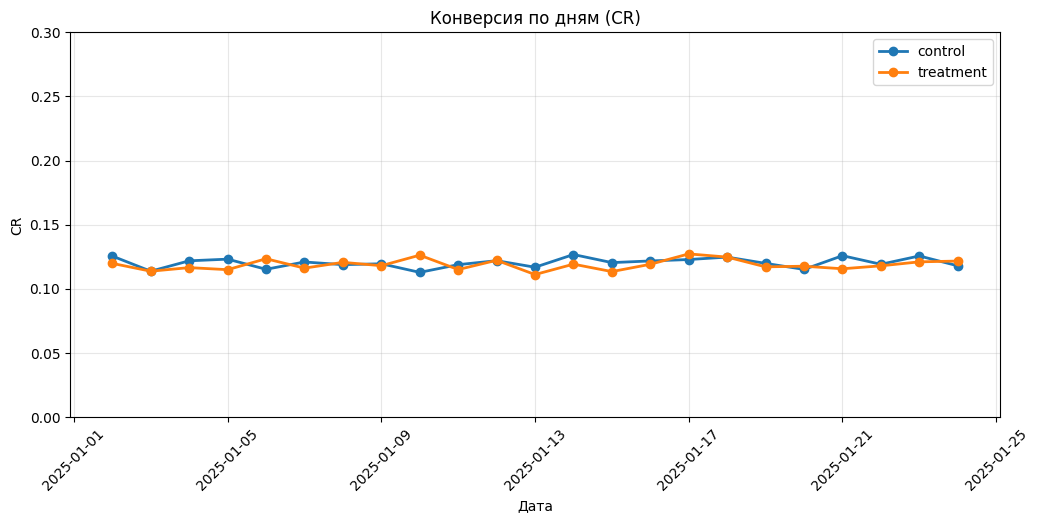

In [24]:
plot_df = cr_table.copy()
plot_df.index = pd.to_datetime(plot_df.index)

plt.figure(figsize=(12, 5))
plt.plot(plot_df.index, plot_df["control"], marker="o", linewidth=2, label="control")
plt.plot(plot_df.index, plot_df["treatment"], marker="o", linewidth=2, label="treatment")

plt.title("Конверсия по дням (CR)")
plt.xlabel("Дата")
plt.ylabel("CR")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.ylim(0, 0.3)
plt.show()

In [25]:
summary = (
    df_clean.groupby("group")
      .agg(users=("user_id","nunique"),
           conversions=("converted","sum"))
)
summary["cr"] = summary["conversions"] / summary["users"]
summary

,users,conversions,cr
group,,,
control,145274,17489,0.120386
treatment,145310,17264,0.118808


Гипотеза: Конверсия контроля равна конверсии в тесте

In [26]:
n_c = summary.loc["control","users"]
n_t = summary.loc["treatment","users"]
x_c = summary.loc["control","conversions"]
x_t = summary.loc["treatment","conversions"]
p_c = x_c / n_c
p_t = x_t / n_t
diff = p_t - p_c                 # абсолютная разница
uplift = p_t / p_c - 1           # относительная
# z-test
p_pool = (x_c + x_t) / (n_c + n_t)
se = (p_pool*(1-p_pool)*(1/n_c + 1/n_t))**0.5
z = diff / se
p_value = 2*(1 - norm.cdf(abs(z)))
# 95% CI для diff (unpooled)
se_u = (p_c*(1-p_c)/n_c + p_t*(1-p_t)/n_t)**0.5
ci_low, ci_high = diff - 1.96*se_u, diff + 1.96*se_u

print("CR control:", p_c)
print("CR treatment:", p_t)
print("ΔCR (t-c):", diff, f"({diff*100:.2f} п.п.)")
print("Uplift:", uplift)
print("z:", z)
print("p-value:", p_value)
print("95% CI for ΔCR:", (ci_low, ci_high))

CR control: 0.1203863045004612
CR treatment: 0.11880806551510564
ΔCR (t-c): -0.0015782389853555567 (-0.16 п.п.)
Uplift: -0.013109788458948057
z: -1.3109241984234394
p-value: 0.18988337448195103
95% CI for ΔCR: (np.float64(-0.003937903604443846), np.float64(0.0007814256337327326))


бутстрап

Размеры групп: 147202 147276


NameError: name 'pe' is not defined

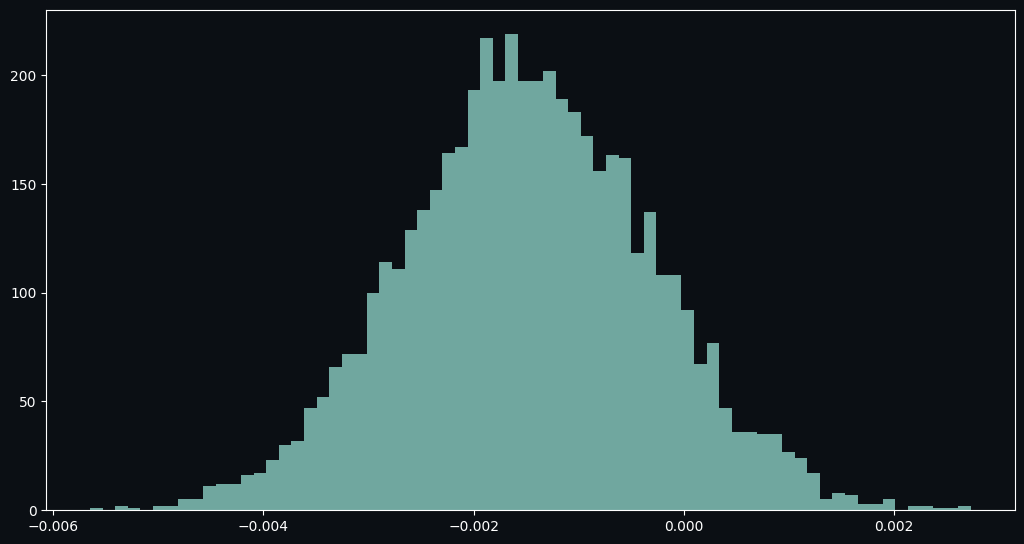

In [28]:
df = pd.read_csv("data_ab.csv")

df["group"] = df["group"].astype(str).str.strip().str.lower()

group_A = df[df["group"] == "control"]["converted"].dropna().values
group_B = df[df["group"] == "treatment"]["converted"].dropna().values

print("Размеры групп:", len(group_A), len(group_B))

def bootstrap_diff(a, b, n_boot=5000):
    boot_diffs = []
    for _ in range(n_boot):
        samp_A = np.random.choice(a, size=len(a), replace=True).mean()
        samp_B = np.random.choice(b, size=len(b), replace=True).mean()
        boot_diffs.append(samp_B - samp_A)
    return np.array(boot_diffs)

boot_diffs = bootstrap_diff(group_A, group_B, 5000)
ci_low, ci_high = np.percentile(boot_diffs, [2.5, 97.5])

plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12.5, 6.5))

fig.patch.set_facecolor("#0b0f14")
ax.set_facecolor("#0b0f14")

counts, bins, patches = ax.hist(
    boot_diffs,
    bins=70,
    alpha=0.78,
    edgecolor="none"
)

for p in patches:
    p.set_path_effects([
        pe.Stroke(linewidth=2.0, foreground="white", alpha=0.06),
        pe.Normal()
    ])

def glow_vline(x, label, ls="--"):
    for lw, a in [(10, 0.05), (6, 0.10), (3.5, 0.18)]:
        ax.axvline(x, linestyle=ls, linewidth=lw, alpha=a)
    line = ax.axvline(x, linestyle=ls, linewidth=2.4, alpha=0.95, label=label)
    line.set_path_effects([pe.Stroke(linewidth=5, foreground="white", alpha=0.10), pe.Normal()])

glow_vline(0, "Null diff (0)")
glow_vline(ci_low, "95% CI low")
glow_vline(ci_high, "95% CI high")

ax.axvspan(ci_low, ci_high, alpha=0.08)

ax.set_title("Bootstrap distribution: (treatment − control)", fontsize=18, fontweight="bold", pad=14)
ax.set_xlabel("Difference in conversion (ΔCR)", fontsize=12, labelpad=10)
ax.set_ylabel("Bootstrap frequency", fontsize=12, labelpad=10)

ax.grid(True, alpha=0.16, linestyle="--")
ax.minorticks_on()
ax.grid(True, which="minor", alpha=0.06, linestyle="--")

ax.spines["top"].set_alpha(0.0)
ax.spines["right"].set_alpha(0.0)
ax.spines["left"].set_alpha(0.35)
ax.spines["bottom"].set_alpha(0.35)
ax.tick_params(colors="#cfd8e3")

leg = ax.legend(frameon=True, fontsize=11, loc="upper right")
leg.get_frame().set_alpha(0.15)
leg.get_frame().set_edgecolor("#3a3f47")

ax.text(
    0.02, 0.95,
    f"95% CI: [{ci_low:.6f}, {ci_high:.6f}]",
    transform=ax.transAxes,
    va="top", ha="left",
    fontsize=11, alpha=0.85,
    bbox=dict(boxstyle="round,pad=0.35", fc="#ffffff14", ec="#ffffff22")
)

plt.show()

сенситивити

Размер контрольной группы: 147202
Размер treatment группы: 147276
Конверсия A: 0.12039917935897611
Конверсия B: 0.11891957956489856

 Минимально детектируемый эффект (MDE): 0.0034 = 0.34%


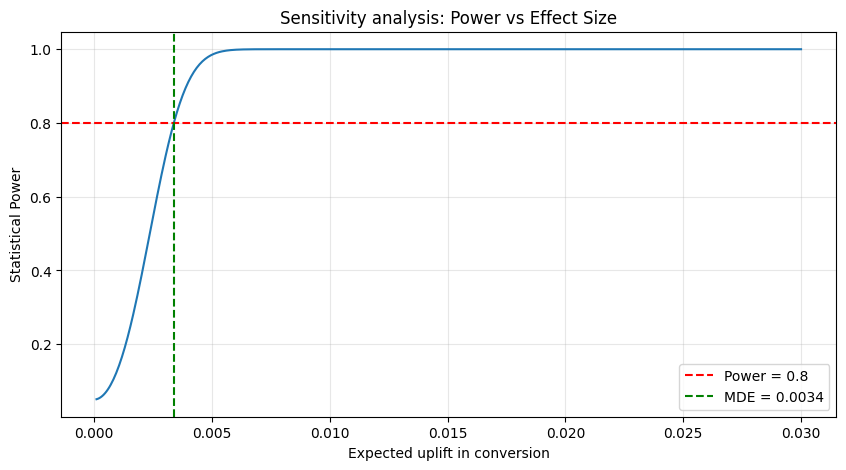

In [27]:
from statsmodels.stats.power import NormalIndPower
import matplotlib.pyplot as plt

df = pd.read_csv("data_ab.csv")

control = df[df["group"] == "control"]
treatment = df[df["group"] == "treatment"]

print("Размер контрольной группы:", len(control))
print("Размер treatment группы:", len(treatment))

def proportion_effectsize(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))
n_A = len(control)
n_B = len(treatment)

p_A = control["converted"].mean()
p_B = treatment["converted"].mean()

print("Конверсия A:", p_A)
print("Конверсия B:", p_B)

alpha = 0.05
power = 0.8
n = min(n_A, n_B)

analysis = NormalIndPower()

effect_sizes = np.linspace(0.0001, 0.03, 500)
powers = []

for mde in effect_sizes:
    es = proportion_effectsize(p_A, p_A + mde)
    pwr = analysis.power(es, nobs1=n, alpha=alpha, ratio=1)
    powers.append(pwr)

idx = np.where(np.array(powers) >= 0.8)[0][0]
MDE = effect_sizes[idx]

print(f"\n Минимально детектируемый эффект (MDE): {MDE:.4f} = {MDE*100:.2f}%")

plt.figure(figsize=(10,5))
plt.plot(effect_sizes, powers)
plt.axhline(0.8, color="red", linestyle="--", label="Power = 0.8")
plt.axvline(MDE, color="green", linestyle="--", label=f"MDE = {MDE:.4f}")
plt.title("Sensitivity analysis: Power vs Effect Size")
plt.xlabel("Expected uplift in conversion")
plt.ylabel("Statistical Power")
plt.grid(alpha=0.3)
plt.legend()
plt.show()